In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env

from flygym import Fly, Camera, SingleFlySimulation

from flygym.examples.vision_connectome_model.arena import *
from flygym.examples.vision_connectome_model.network import *
from flygym.examples.vision_connectome_model.viz import *
from flygym.examples.vision_connectome_model.controller import *

#from flygym.mujoco import Parameters
#from flygym.mujoco.arena import FlatTerrain
#from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
#from flygym.mujoco.examples.turning_controller import HybridTurningNMF

In [5]:
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

 50%|█████     | 1/2 [00:07<00:07,  7.43s/it]

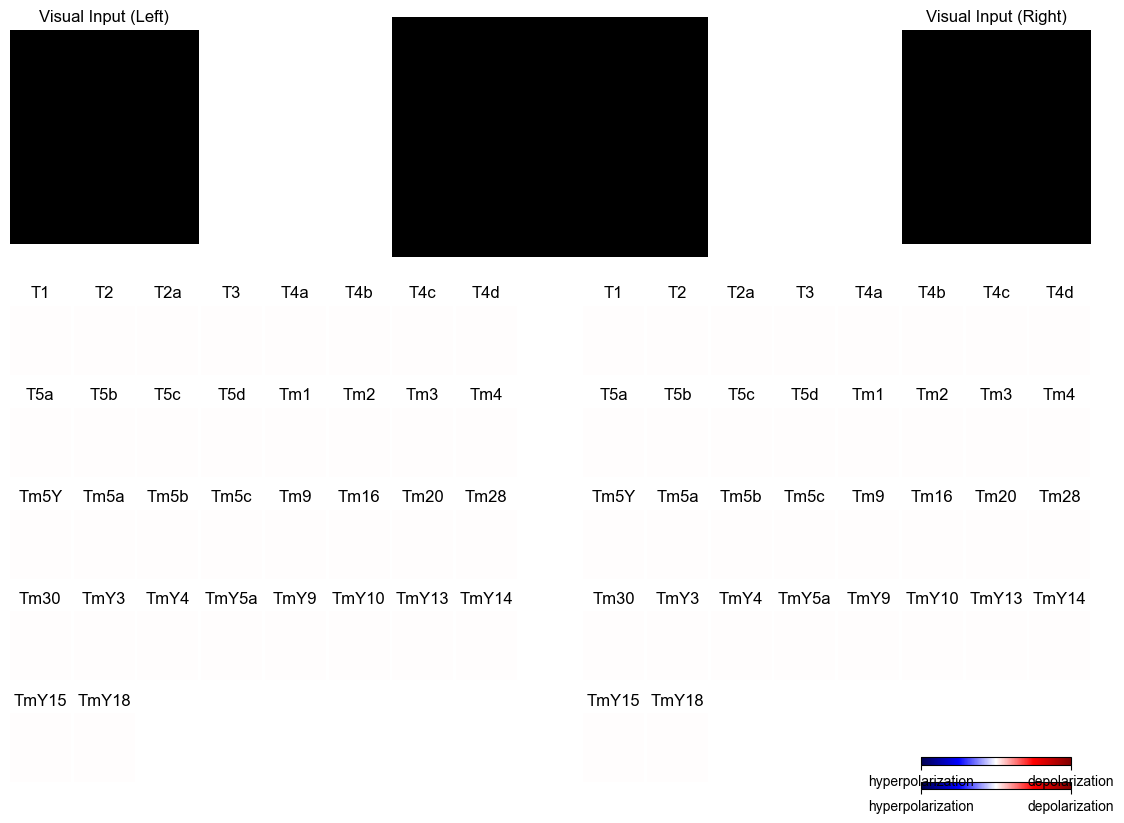

In [8]:
#response_to_fly.py
import pickle
import numpy as np
from pathlib import Path
from tqdm import trange
from flygym import Fly, Camera
from typing import Optional
from dm_control.rl.control import PhysicsError

from flygym.examples.vision_connectome_model import (
    MovingFlyArena,
    NMFRealisticVision,
    visualize_vision,
)
from flygym.examples.head_stabilization import HeadStabilizationInferenceWrapper
from flygym.examples.head_stabilization import get_head_stabilization_model_paths


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# fmt: off
cells = [
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm2", "Tm3", "Tm4", "Tm5Y", "Tm5a", "Tm5b", "Tm5c", "Tm9", "Tm16", "Tm20",
    "Tm28", "Tm30", "TmY3", "TmY4", "TmY5a", "TmY9", "TmY10", "TmY13", "TmY14", "TmY15",
    "TmY18"
]
# fmt: on

output_dir = Path("./outputs/connectome_constrained_vision/baseline_response/")

# If you trained the models yourself (by running ``collect_training_data.py``
# followed by ``train_proprioception_model.py``), you can use the following
# paths to load the models that you trained. Modify the paths if saved the
# model checkpoints elsewhere.
#stabilization_model_dir = Path("./outputs/head_stabilization/models/")
#stabilization_model_path = stabilization_model_dir / "All.ckpt"
#scaler_param_path = stabilization_model_dir / "joint_angle_scaler_params.pkl"

# Alternatively, you can use the pre-trained models that come with the
# package. To do so, comment out the three lines above and uncomment the
# following line.
stabilization_model_path, scaler_param_path = get_head_stabilization_model_paths()


def run_simulation(
    arena: MovingFlyArena,
    run_time: float = 1.0,
    head_stabilization_model: Optional[HeadStabilizationInferenceWrapper] = None,
):
    fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        enable_adhesion=True,
        enable_vision=True,
        vision_refresh_rate=500,
        neck_kp=1000,
        head_stabilization_model=head_stabilization_model,
    )

    cam = Camera(
        fly=fly,
        camera_id="birdeye_cam",
        play_speed=0.2,
        window_size=(800, 608),
        fps=24,
        play_speed_text=False,
    )

    sim = NMFRealisticVision(
        fly=fly,
        cameras=[cam],
        arena=arena,
    )

    sim.reset(seed=0)
    obs_hist = []
    info_hist = []
    rendered_image_snapshots = []
    vision_observation_snapshots = []
    nn_activities_snapshots = []

    # Main simulation loop
    for i in trange(int(run_time / sim.timestep)):
        try:
            obs, _, _, _, info = sim.step(action=np.array([1, 1]))
        except PhysicsError:
            print("Physics error, ending simulation early")
            break
        obs_hist.append(obs)
        info_hist.append(info)
        rendered_img = sim.render()[0]
        if rendered_img is not None:
            rendered_image_snapshots.append(rendered_img)
            vision_observation_snapshots.append(obs["vision"])
            nn_activities_snapshots.append(info["nn_activities"])

    return {
        "sim": sim,
        "obs_hist": obs_hist,
        "info_hist": info_hist,
        "rendered_image_snapshots": rendered_image_snapshots,
        "vision_observation_snapshots": vision_observation_snapshots,
        "nn_activities_snapshots": nn_activities_snapshots,
    }


def process_trial(terrain_type: str, stabilization_on: bool):
    variation_name = f"{terrain_type}terrain_stabilization{stabilization_on}"

    if terrain_type == "flat":
        arena = MovingFlyArena(
            move_speed=18, lateral_magnitude=1, terrain_type=terrain_type
        )
    elif terrain_type == "blocks":
        arena = MovingFlyArena(
            move_speed=13, lateral_magnitude=1, terrain_type=terrain_type
        )
    else:
        raise ValueError("Invalid terrain type")
    if stabilization_on:
        stabilization_model = HeadStabilizationInferenceWrapper(
            model_path=stabilization_model_path,
            scaler_param_path=scaler_param_path,
        )
    else:
        stabilization_model = None

    # Run simulation
    res = run_simulation(
        arena=arena, run_time=0.01, head_stabilization_model=stabilization_model
    )

    # Save visualization
    visualize_vision(
        Path(output_dir / f"{variation_name}_vision_simulation.mp4"),
        res["sim"].fly.retina,
        res["sim"].retina_mapper,
        rendered_image_hist=res["rendered_image_snapshots"],
        vision_observation_hist=res["vision_observation_snapshots"],
        nn_activities_hist=res["nn_activities_snapshots"],
        fps=res["sim"].cameras[0].fps,
    )

    # Save median and std of response for each cell
    response_stats = {}
    for cell in cells:
        response_all = np.array(
            [info["nn_activities"][cell] for info in res["info_hist"]]
        )
        response_mean = np.mean(response_all, axis=0)
        response_std = np.std(response_all, axis=0)
        response_stats[cell] = {
            "mean": res["sim"].retina_mapper.flyvis_to_flygym(response_mean),
            "std": res["sim"].retina_mapper.flyvis_to_flygym(response_std),
        }
    with open(output_dir / f"{variation_name}_response_stats.pkl", "wb") as f:
        pickle.dump(response_stats, f)


if __name__ == "__main__":
    from joblib import Parallel, delayed

    output_dir.mkdir(exist_ok=True, parents=True)

    configs = [
        (terrain_type, stabilization_on)
        for terrain_type in ["flat"]#, "blocks"]
        for stabilization_on in [True]#, False]
    ]
    process_trial('flat', True)
    #Parallel(n_jobs=-8)(delayed(process_trial)(*config) for config in configs)

In [ ]:
#follow_fly_closed_loop.py
import cv2
import pickle
import numpy as np
from pathlib import Path
from tqdm import trange
from typing import Optional
from flygym import Fly, Camera
from dm_control.rl.control import PhysicsError

from flygym.examples.vision_connectome_model import (
    MovingFlyArena,
    NMFRealisticVision,
    visualize_vision,
)
from flygym.examples.head_stabilization import HeadStabilizationInferenceWrapper
from flygym.examples.head_stabilization import get_head_stabilization_model_paths


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# fmt: off
cells = [
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm2", "Tm3", "Tm4", "Tm5Y", "Tm5a", "Tm5b", "Tm5c", "Tm9", "Tm16", "Tm20",
    "Tm28", "Tm30", "TmY3", "TmY4", "TmY5a", "TmY9", "TmY10", "TmY13", "TmY14", "TmY15",
    "TmY18"
]
# fmt: on

baseline_dir = Path("./outputs/connectome_constrained_vision/baseline_response/")
output_dir = Path("./outputs/connectome_constrained_vision/closed_loop_control/")

# If you trained the models yourself (by running ``collect_training_data.py``
# followed by ``train_proprioception_model.py``), you can use the following
# paths to load the models that you trained. Modify the paths if saved the
# model checkpoints elsewhere.
#stabilization_model_dir = Path("./outputs/head_stabilization/models/")
#stabilization_model_path = stabilization_model_dir / "All.ckpt"
#scaler_param_path = stabilization_model_dir / "joint_angle_scaler_params.pkl"

# Alternatively, you can use the pre-trained models that come with the
# package. To do so, comment out the three lines above and uncomment the
# following line.
stabilization_model_path, scaler_param_path = get_head_stabilization_model_paths()


def run_simulation(
    arena: MovingFlyArena,
    cell: str,
    run_time: float,
    response_mean: np.ndarray,
    response_std: np.ndarray,
    z_score_threshold: float,
    tracking_gain: float,
    head_stabilization_model: Optional[HeadStabilizationInferenceWrapper] = None,
):
    # Setup NMF simulation
    fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        enable_adhesion=True,
        enable_vision=True,
        vision_refresh_rate=500,
        neck_kp=500,
        head_stabilization_model=head_stabilization_model,
    )
    cam = Camera(
        fly=fly,
        camera_id="birdeye_cam",
        play_speed=0.2,
        window_size=(800, 608),
        fps=24,
        play_speed_text=False,
    )
    sim = NMFRealisticVision(fly=fly, cameras=[cam], arena=arena)

    # Calculate center-of-mass of each ommatidium
    ommatidia_coms = np.empty((fly.retina.num_ommatidia_per_eye, 2))
    for i in range(fly.retina.num_ommatidia_per_eye):
        mask = fly.retina.ommatidia_id_map == i + 1
        ommatidia_coms[i, :] = np.argwhere(mask).mean(axis=0)

    # Run simulation
    obs, info = sim.reset(seed=0)
    obs_hist = []
    info_hist = []
    rendered_image_snapshots = []
    vision_observation_snapshots = []
    nn_activities_snapshots = []

    dn_drive = np.array([1, 1])
    for i in trange(int(run_time / sim.timestep)):
        if info["vision_updated"]:
            # Estimate object mask
            nn_activities = info["nn_activities"]
            t3_activities = sim.retina_mapper.flyvis_to_flygym(nn_activities[cell])
            t3_zscore = (t3_activities - response_mean) / response_std
            obj_mask = t3_zscore < z_score_threshold
            _mask_viz = fly.retina.hex_pxls_to_human_readable(obj_mask[1])
            cv2.imwrite(f"temp/{i}.jpg", _mask_viz.astype(np.uint8) * 255)

            # Calculate turning bias based on object mask
            size_per_eye = obj_mask.sum(axis=1)
            com_per_eye = np.full((2, 2), np.nan)
            for eye_idx in range(2):
                if size_per_eye[eye_idx] > 0:
                    masked_xy_coords = ommatidia_coms[obj_mask[eye_idx], :]
                    com_per_eye[eye_idx, :] = masked_xy_coords.mean(axis=0)
            com_per_eye /= np.array([fly.retina.nrows, fly.retina.ncols])
            size_per_eye = size_per_eye / fly.retina.num_ommatidia_per_eye
            center_deviation = com_per_eye[:, 1].copy()
            center_deviation[0] = 1 - center_deviation[0]
            _center_deviation = center_deviation.copy()
            _center_deviation[size_per_eye == 0] = 1e9  # make sure it will break
            if size_per_eye.sum() == 0:
                turning_bias = 0
            else:
                turning_bias = (
                    -size_per_eye[0] * _center_deviation[0]
                    + size_per_eye[1] * _center_deviation[1]
                ) / size_per_eye.sum()

            # Calculate DN drive based on turning bias
            dn_inner = max(0.4, 1 - np.abs(turning_bias * tracking_gain) * 0.6)
            dn_outer = min(1.2, 1 + np.abs(turning_bias * tracking_gain) * 0.2)
            if turning_bias < 0:
                dn_drive = np.array([dn_inner, dn_outer])
            else:
                dn_drive = np.array([dn_outer, dn_inner])

        try:
            obs, _, _, _, info = sim.step(action=dn_drive)
        except PhysicsError:
            print("Physics error, breaking simulation")
            break
        rendered_img = sim.render()[0]
        info["com_per_eye"] = com_per_eye
        info["size_per_eye"] = size_per_eye
        info["center_deviation"] = center_deviation
        info["turning_bias"] = turning_bias
        obs_hist.append(obs)
        info_hist.append(info)
        if rendered_img is not None:
            rendered_image_snapshots.append(rendered_img)
            vision_observation_snapshots.append(obs["vision"])
            nn_activities_snapshots.append(info["nn_activities"])

    return {
        "sim": sim,
        "obs_hist": obs_hist,
        "info_hist": info_hist,
        "rendered_image_snapshots": rendered_image_snapshots,
        "vision_observation_snapshots": vision_observation_snapshots,
        "nn_activities_snapshots": nn_activities_snapshots,
    }


def process_trial(terrain_type: str, stabilization_on: bool):
    variation_name = f"{terrain_type}terrain_stabilization{stabilization_on}"

    with open(baseline_dir / f"{variation_name}_response_stats.pkl", "rb") as f:
        response_stats = pickle.load(f)

    if terrain_type == "flat":
        arena = MovingFlyArena(
            move_speed=16, lateral_magnitude=1, terrain_type=terrain_type
        )
    elif terrain_type == "blocks":
        arena = MovingFlyArena(
            move_speed=13, lateral_magnitude=1, terrain_type=terrain_type
        )
    else:
        raise ValueError("Invalid terrain type")
    if stabilization_on:
        stabilization_model = HeadStabilizationInferenceWrapper(
            model_path=stabilization_model_path,
            scaler_param_path=scaler_param_path,
        )
    else:
        stabilization_model = None

    # Run simulation
    res = run_simulation(
        arena=arena,
        cell="T3",
        run_time=2.0,
        response_mean=response_stats["T3"]["mean"],
        response_std=response_stats["T3"]["std"],
        z_score_threshold=-4,
        tracking_gain=4,
        head_stabilization_model=stabilization_model,
    )

    # Save visualization
    visualize_vision(
        Path(output_dir / f"{variation_name}_vision_simulation.mp4"),
        res["sim"].fly.retina,
        res["sim"].retina_mapper,
        rendered_image_hist=res["rendered_image_snapshots"],
        vision_observation_hist=res["vision_observation_snapshots"],
        nn_activities_hist=res["nn_activities_snapshots"],
        fps=res["sim"].cameras[0].fps,
    )

    # Save sim data for diagnostics
    try:
        with open(output_dir / f"{variation_name}_sim_data.pkl", "wb") as f:
            # Remove sim, and remove LayerResponse from info_hist. They
            # work poorly with pickle
            del res["sim"]
            for info in res["info_hist"]:
                del info["nn_activities"]
            pickle.dump(res, f)
    except Exception as e:
        print(f"Failed to save sim data for {variation_name}: {e}")


if __name__ == "__main__":
    from joblib import Parallel, delayed

    output_dir.mkdir(exist_ok=True, parents=True)

    configs = [
        (terrain_type, stabilization_on)
        for terrain_type in ["flat"]#, "blocks"]
        for stabilization_on in [True]#, False]
    ]
    process_trial('flat', True)
    #Parallel(n_jobs=-8)(delayed(process_trial)(*config) for config in configs)